# Introduction to MCMC


## Takeaways and objectives from this notebook
1. The concept of Gibbs sampling using full conditional distributions. When is Gibbs sampling suitable?
2. Gibbs sampler as a Metropolis method with 100% acceptance rate.

## Gibbs sampling
So-far we have seen the Metropolis algorithm as the workhorse of sampling from a posterior distribution.  Another method of accomplishing the same is Gibbs sampling, which rests on different justifications and has different properties.

Gibbs sampling is the method of sampling from *full conditional posteriors*, so we need to compute the conditional distribution of each variable given the others and sample from that.

The exact algorithm assuming that our state vector has $n$ variables $\mathbf{x}^{(t)} = [x_1^{(t)}, x_2^{(t)}, ..., x_n^{(t)}]$, the Gibbs sampler proceeds to sample $\mathbf{x}^{(t+1)}$ as follows:

1. Sample $x_1^{(t+1)}$ from $p(x_1^{(t+1)} \mid x_2^{(t)}, ..., x_n^{(t)})$,
2. Sample $x_2^{(t+1)}$ from $p(x_2^{(t+1)} \mid x_1^{(t+1)}, x_2^{(t)}, ..., x_n^{(t)})$
3. ...
4. Sample $x_i^{(t+1)}$ from $p(x_i^{(t+1)} \mid x_1^{(t+1)}, ..., x_{i-1}^{(t+1)}, x_{i+1}^{(t)}, ..., x_n^{(t)})$
5. ...
6. Sample $x_n^{(t+1)}$ from $p(x_n^{(t+1)} \mid x_2^{(t+1)}, ..., x_{n-1}^{(t+1)}$.

We then set $\mathbf{x}^{(t+1)} = [x_1^{(t+1)}, ..., x_{n-1}^{(t+1)}]$, as expected. So theoretically the algorithm is very simple.  Programmatically we can think of the algorithm as going through the variables from first to last and updating them in-place.  On the $i$-th variable, we simply use all the updated values for variables $0..i-1$.

The main difficulty in applying the Gibbs sampling algorithm is the analytical work required to derive the conditional distributions.

### Example: Ising model
A very popular example for the Gibbs algorithm is the [Ising model](https://en.wikipedia.org/wiki/Ising_model) which can be observed live for example on [this page](https://cs.stanford.edu/people/karpathy/visml/ising_example.html) [1].

A simple version of an Ising model is a two-dimensional lattice of binary variables $x_i \in \{-1,+1\}$ that are horizontally and vertically connected using pairwise factor potentials.  

![Ising model](https://jgtechnologysolutions.files.wordpress.com/2017/02/ising.png?w=620)
Image source: https://jgtechnologysolutions.org

We may also apply a potential field $\bf{b}$, which attract some elements of the Ising model toward 1 o toward -1.  The total *energy* of the field is given by the Hamiltonia and can then be written as:

$$H(\textbf{x}) = - J \sum_{(i,j) \in E} x_i x_j - J_b \sum_{i \in V} b_i x_i,$$

where $J$ is the strength of the interactions, $J_b$ is the strength of the external field and $b_i$ are the desired values. The first sum is over edges connecting the elements (see figure below) and the other is over the elements themselves.

We define the (unnormalized) distribution over states to be:

$$\pi(\textbf{x}) = \exp (- H(\textbf{x}))
\left ( J \sum_{(i,j) \in E} x_i x_j + J_b \sum_{i \in V} b_i x_i \right )$$

The $\pi(x)$ distribution is our posterior that we wish to sample from (we didn't explictly build any priors or data likelihood - let's assume that the function above is the result of such considerations). Let's break down how the probability depends on a value of a fixed element $x_i$.

Hence forth we will denote $E_i(x_i)$ as the part of the energy $E$ that depends on $x_i$ and $E_{-i}$ as the rest of the function. In Gibbs sampling we select one (or more) variables that we want to update and the rest of the model (here represented by $E_{-i}$ remains unchanged. For concreteness, we only select a single variable to update here. Note that $E = E_i(x_i) + E_{-i}$.

For the purposes of analyzing the update, we will denote the neighbouring nodes $x_a, x_b, x_c, x_d$.

For Gibbs sampling, we need to compute $\pi(x_i \mid x_{-i})$ which can be computed as

$$ \pi(x_i = v \mid x_{-i}) = \frac{\pi(x_i=v \mid x_{-i})}{\pi(x_i=+1 \mid x_{-i}) + \pi(x_i=-1 \mid x_{-i})}.$$

Where $v \in \{ -1, +1 \}$.

**Note** that here we casually sidestep the normalization problem. Normalization is intractable for the entire model $\pi(x)$ but since here we restricted our analysis only to one variable, it's easy and is solved by the formula above, which returns a valid conditional distribution $\pi(x_i = v \mid x_{-i})$ even if $\pi(x)$ is not normalized.

These considerations lead us to consider $E_i(x_i)$ and $E_{-1}$.  Rewriting the equation in logs again, we get

$$ \pi(x_i = +1 \mid x_{-i}) = \frac{\exp(E_i(x_i=+1) + E_{-i})}{\exp(E_i(x_i=+1)+E_{-i}) + \exp(E_i(x_i=+1)+E_{-i}) }$$

from which we can factor and cancel out $E_{-i}$ to obtain

$$ \pi(x_i = +1 \mid x_{-i}) = \frac{\exp(E_i(x_i=+1))}{\exp(E_i(x_i=+1)) + \exp(E_i(x_i=-1))}.$$

**Note** that this results in a huge computational efficiency gain, we can evaluate the conditional with respect to only the neighbouring nodes as the state of $x_i$ is conditionally independent from the rest of the model given it's neighbors.  In effect, we can compute the posterior in O(1) time and update the entire state in $O(N)$ time where $N$ is the number of elements.

We thus have

$$E_i(x_i) = J(x_ix_a + x_ix_b + x_ix_c + x_ix_d) + J_bb_ix_i,$$

which factorizes nicely

$$E_i(x_i) = x_i \left ( J (x_a + x_b + x_c + x_d) + J_bb_i \right ),$$

which makes the value extremely simple to compute for both options $x_i=+1$ and $x_i=-1$.


In [1]:
import numpy as np
import numpy.random as nr

# rows and columns
rows, cols = 8, 8

b = np.array([[-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, +1, -1, +1, +1, -1, -1],
              [-1, -1, +1, +1, +1, +1, -1, -1],
              [-1, -1, +1, -1, +1, -1, -1, -1],
              [-1, -1, +1, +1, +1, +1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1]])

In [2]:
def random_state(prob_one):
    X = np.where(nr.uniform(size=(8,8)) < 1. - prob_one, -1, +1)
    return X

X_init = random_state(0.5)
X_init

array([[-1,  1, -1, -1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1,  1,  1],
       [-1,  1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1,  1, -1, -1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1,  1],
       [-1,  1, -1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  1,  1, -1],
       [ 1,  1, -1, -1,  1, -1, -1,  1]])

In [3]:
def compute_hamiltonian(X, b, J, Jb):
    H = 0.0
    
    for r in range(rows):
        for c in range(cols):
            # evaluate the E_i term for the actual value of X[r,c]
            # sum over elements
            H -= Jb * b[r,c] * X[r,c]
            
            # sum over edges
            if r > 0:
                H -= J * X[r-1,c] * X[r,c]
            if c > 0:
                H -= J * X[r, c-1] * X[r,c]
    return H

In [4]:
H = compute_hamiltonian(X_init, b, 1., 1.)
pi = np.exp(-H)
H, pi

(26.0, 5.109089028063325e-12)

In [5]:
def compute_conditional_xi_is_minus1(X,b,r,c,J,Jb):
    sum_xabcd = 0.0
    if c > 0:
        sum_xabcd += X[r,c-1]
    if c < cols-1:
        sum_xabcd += X[r,c+1]
    if r > 0:
        sum_xabcd += X[r-1,c]
    if r < rows-1:
        sum_xabcd += X[r+1,c]
        
    factor = - J * sum_xabcd - Jb * b[r,c]
    pi_i_xi_minus1 = np.exp(- (-1. * factor))
    pi_i_xi_plus1 = np.exp(- (+1. * factor))
    return pi_i_xi_minus1 / (pi_i_xi_minus1 + pi_i_xi_plus1)

In [6]:
compute_conditional_xi_is_minus1(X_init, b, 2, 1, 1., 0.5)

0.04742587317756678

In [7]:
# let's make sure our conditional computation works

# compute conditional from definition
X = random_state(0.5)
X[4,4] = +1.
pi_x_plus1 = np.exp(-compute_hamiltonian(X, b, 0.8, 0.5))
X[4,4] = -1
pi_x_minus1 = np.exp(-compute_hamiltonian(X, b, 0.8, 0.5))
cond_p_xi_minus1 = pi_x_minus1 / (pi_x_minus1 + pi_x_plus1)

# now we compute the conditional using our nifty function
cond_p_xi_minus1_fast = compute_conditional_xi_is_minus1(X, b, 4, 4, 0.8, 0.5)

print('Full computation: %g  incremental computation: %g' % (cond_p_xi_minus1, cond_p_xi_minus1_fast))

Full computation: 0.000610879  incremental computation: 0.000610879


In [8]:
def run_gibbs_sampler(X, b, J, Jb, steps=1):
    # note that X is modified in place
    for s in range(steps):
        # pre-sample a bunch of uniform random numbers
        random_buffer = np.random.uniform(size=(rows, cols))
        for r in range(rows):
            for c in range(cols):
                cond_p_xi_minus1 = compute_conditional_xi_is_minus1(X, b, r, c, J, Jb)
                X[r,c] = -1. if random_buffer[r,c] < cond_p_xi_minus1 else +1.

In [9]:
Xstate = np.copy(X_init)
run_gibbs_sampler(Xstate, b, 1., 0.5)
Xstate

array([[ 1,  1, -1, -1,  1,  1,  1,  1],
       [-1,  1,  1, -1, -1,  1,  1,  1],
       [-1,  1,  1, -1, -1, -1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1],
       [ 1,  1,  1, -1, -1,  1,  1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1,  1, -1, -1, -1, -1, -1, -1]])

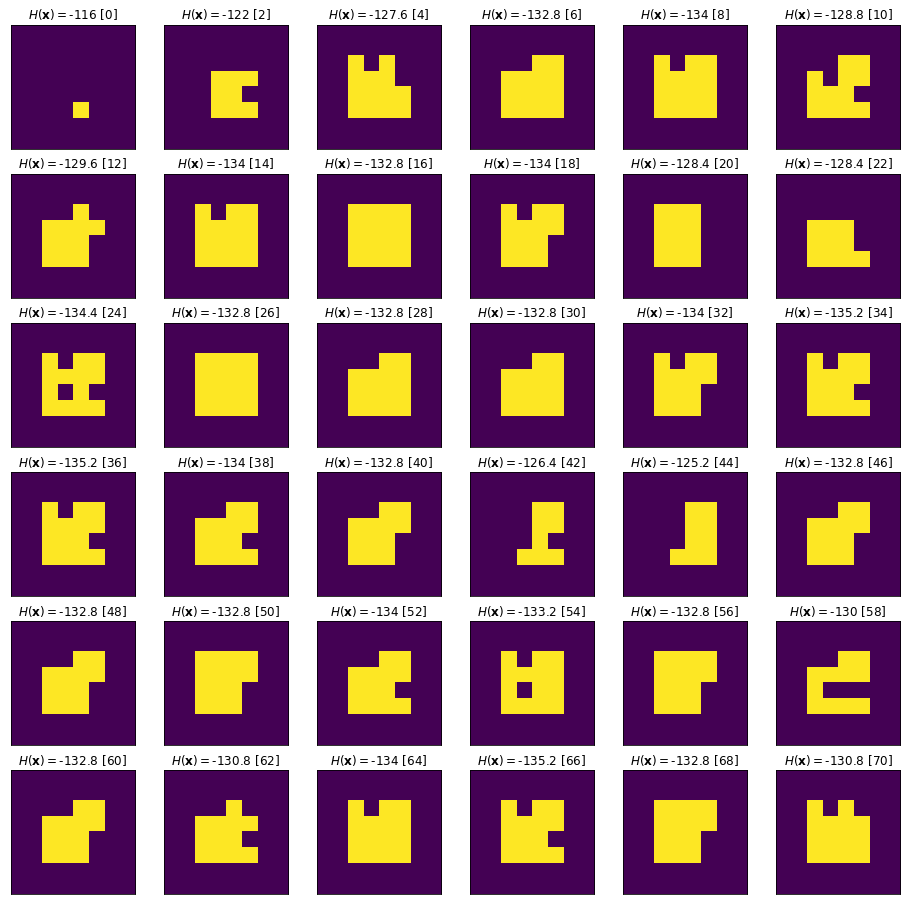

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

steps_per_iter = 2

plt.figure(figsize=(16,16))
Xstate = random_state(0.1)
for step in range(36):
    plt.subplot(6,6,step+1)
    plt.imshow(Xstate)
    plt.xticks([])
    plt.yticks([])
    plt.title('$H({\\bf x})=$%g [%d]' % (compute_hamiltonian(Xstate, b, 0.5, 1.6), step*steps_per_iter))
    run_gibbs_sampler(Xstate, b, 0.8, 1.6, steps=steps_per_iter)

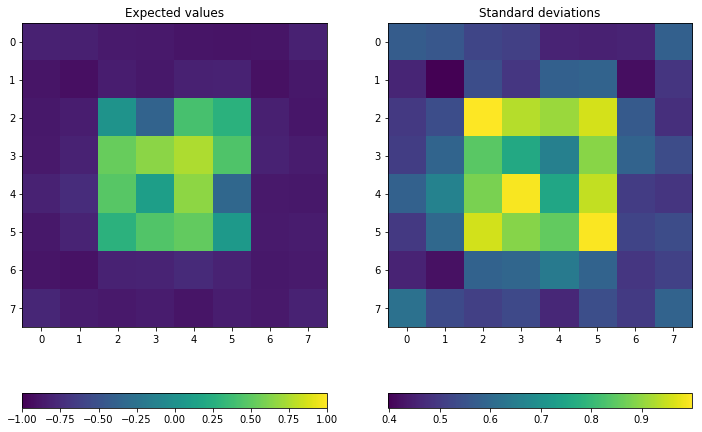

In [11]:
# let's grab 500 samples
N = 1000
X = random_state(0.5)
Xs = np.zeros((N, rows, cols))
for i in range(N):
    # variable is modified in place
    run_gibbs_sampler(X, b, 0.3, 0.6)
    Xs[i,:,:] = X

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.mean(Xs, axis=0))
plt.title('Expected values')
plt.colorbar(orientation='horizontal')
plt.clim([-1,1])
plt.subplot(1,2,2)
plt.imshow(np.std(Xs, axis=0))
plt.colorbar(orientation='horizontal')
plt.title('Standard deviations');

## Metropolis-within-Gibbs

The Gibbs algorithm requires that we can derive and evaluate conditional probabilities for all variables.  This is impractical in many situations.

In such cases, it's possible to to sample with a design called Metropolis-within-Gibbs, where we combine Gibbs and Metropolis sampling.

Let's solve a simple mixture problem with two gaussian mixtures that we want to fit a set of points $d_i, i=1,...,40$ in one dimension.

$$\begin{array}{rcl}
   \mu_0 &\sim& {\cal N}(0,10) \\
   \mu_1 &\sim& {\cal N}(0,10) \\
   Z_i &\sim& \text{Bernoulli}(0.5) \\
   d_i &\sim& {\cal N}(\mu_0(1-Z_i) + \mu_1 Z_i) \\
\end{array}$$

Writing a Metropolis sampler for this data should be a breeze, but this time we will do something different: write a hybrid sampler that uses different methods of proposing for different variables:

- $\mu_0, \mu_1$ using Metropolis random walk and
- $Z$ using Gibbs sampling.

In [12]:
def generate_data(mu1, mu2, N):
    return np.hstack([nr.randn(N) + mu1, nr.randn(N) + mu2])

def log_normal(x, mu, sd):
    return - np.log(sd) - 0.5 * (x - mu)**2/sd**2

def log_prior(v):
    return log_normal(v['mu0'], 0, 10) + log_normal(v['mu0'], 0, 10) + len(v['Z']) * np.log(0.5)

def log_likelihood(v, data):
    Z = v['Z']
    return np.sum(log_normal(data, v['mu0'] * (1-Z) + v['mu1'] * Z, 1.0))

def log_posterior(v, data):
    ordering_potential = -np.inf if v['mu0'] > v['mu1'] else 0.
    return log_prior(v) + log_likelihood(v, data) + ordering_potential

In [13]:
# Let's make the problem easy :)
N = 20
true_mu0, true_mu1 = 2.0, 5.0
data = generate_data(true_mu0, true_mu1, N)

In [14]:
import seaborn as sns

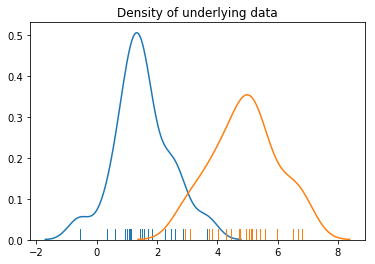

In [15]:
sns.distplot(data[:N], hist=False, rug=True)
sns.distplot(data[N:], hist=False, rug=True)
plt.title('Density of underlying data');

In [16]:
data

array([ 1.1091317 ,  1.12444985, -0.56789798,  2.27048421,  1.01067132,
        1.42061154,  1.07599817,  1.58032896,  2.47292394,  1.7142172 ,
        1.43097273,  2.87345385,  1.51477457,  2.58246093,  3.64863857,
        0.35320824,  0.6194785 ,  0.93060535,  1.8278183 ,  1.45074955,
        5.40144888,  6.66846792,  5.15598982,  2.93405242,  4.02362913,
        5.05999809,  3.81805793,  5.98538221,  3.09432721,  4.72030043,
        5.11823966,  6.82255751,  5.295066  ,  4.44181074,  4.95862007,
        3.7123709 ,  4.75880969,  5.56571301,  6.49490348,  4.30084801])

In [28]:
v_init = {
    'mu0': nr.randn() * 10,
    'mu1': nr.randn() * 10,
    'Z' : np.where(nr.rand(2*N) < 0.5, 0, 1)
}

# ensure ordering holds
if v_init['mu1'] < v_init['mu0']:
    v_init['mu0'], v_init['mu1'] = v_init['mu1'], v_init['mu0']

v_init, log_posterior(v_init, data)

({'Z': array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]),
  'mu0': -5.799920244251474,
  'mu1': 6.22216236645091},
 -989.5015457773334)

In [29]:
log_prior(v_init), log_likelihood(v_init, data)

(-32.66744815678268, -956.8340976205507)

In [30]:
def plot_state(v):
    global data
    Z=v['Z']    
    plt.plot([v['mu0']], [0.1], 'go')
    plt.plot([v['mu1']], [0.1], 'ro')
    sns.distplot(data[Z==0], hist=False, rug=True)
    sns.distplot(data[Z==1], hist=False, rug=True)

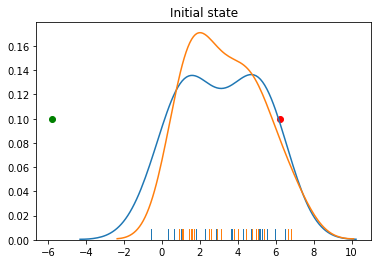

In [31]:
plot_state(v_init)
plt.title('Initial state');

In [32]:
def propose_mus(v, logp):
    v_prime = { 'mu0' : v['mu0'] + nr.randn() * 0.5,
                'mu1' : v['mu1'] + nr.randn() * 0.5,
                'Z' : v['Z']
              }
    
    logp_prime = log_posterior(v_prime, data)
    if logp_prime - logp > np.log(nr.rand()):
        return v_prime, logp_prime, True
    else:
        return v, logp, False
    
    
def propose_gibbs(v, logp):
    mu0, mu1, Z = v['mu0'], v['mu1'], v['Z']
    Z0s = log_normal(data, mu0, 1.0)
    Z1s = log_normal(data, mu1, 1.0)
    Zmax = np.amax(np.vstack([Z0s, Z1s]), axis=0)
    C_hats = Zmax + np.log(np.exp(Z0s - Zmax) + np.exp(Z1s - Zmax))
    
    Znew = np.where(np.log(nr.uniform(size=Z.shape)) < Z0s - C_hats, 0, 1)
    
    v_prime = {
        'mu0' : v['mu0'],
        'mu1' : v['mu1'],
        'Z' : Znew
    }
    
    logp_prime = log_posterior(v_prime, data)
    if logp_prime - logp > np.log(nr.rand()):
        return v_prime, logp_prime, True
    else:
        return v, logp, False

In [33]:
def metropolis_within_gibbs(v_init, n, status_period = None):
    global data
    
    v, logp = v_init, log_posterior(v_init, data)
    states, states_logp = [v_init], [logp]
    was_accept1, was_accept2 = [], []
    
    if status_period is None:
        status_period = n // 10
    
    for i in range(1,n):
                
        # propose mu1 and mu2 via a Metropolis step
        v1, logp_v1, accept1 = propose_mus(v, logp)
        was_accept1.append(accept1)
        
        # now v1, logp_v1 are either v, logp if a reject occured or a new state
        v2, logp_v2, accept2 = propose_gibbs(v1, logp_v1)
        was_accept2.append(accept2)
        
        # append whatever came out
        states.append(v2)
        states_logp.append(logp_v2)
        
        v, logp = v2, logp_v2
            
        if i > 1 and i % status_period == 0:
            print('Stats @ %d: accept1_ratio=%g avg_logp=%g' % (i, float(np.sum(was_accept1[-status_period:]))/status_period,
                                                                   np.mean(states_logp[-status_period:])))
            
    return states, float(np.sum(was_accept1)) / n, float(np.sum(was_accept2)) / n

In [34]:
states, ar1, ar2 = metropolis_within_gibbs(v_init, 10000, status_period=1000)
ar1, ar2

Stats @ 1000: accept1_ratio=0.26 avg_logp=-57.2347
Stats @ 2000: accept1_ratio=0.237 avg_logp=-50.5933
Stats @ 3000: accept1_ratio=0.236 avg_logp=-50.7795
Stats @ 4000: accept1_ratio=0.247 avg_logp=-50.9907
Stats @ 5000: accept1_ratio=0.253 avg_logp=-50.8994
Stats @ 6000: accept1_ratio=0.228 avg_logp=-50.5902
Stats @ 7000: accept1_ratio=0.242 avg_logp=-50.6741
Stats @ 8000: accept1_ratio=0.229 avg_logp=-50.4907
Stats @ 9000: accept1_ratio=0.235 avg_logp=-50.8241


(0.2405, 0.4089)

In [35]:
mu0s = np.array([s['mu0'] for s in states])
mu1s = np.array([s['mu1'] for s in states])
Zs = np.vstack([s['Z'] for s in states])

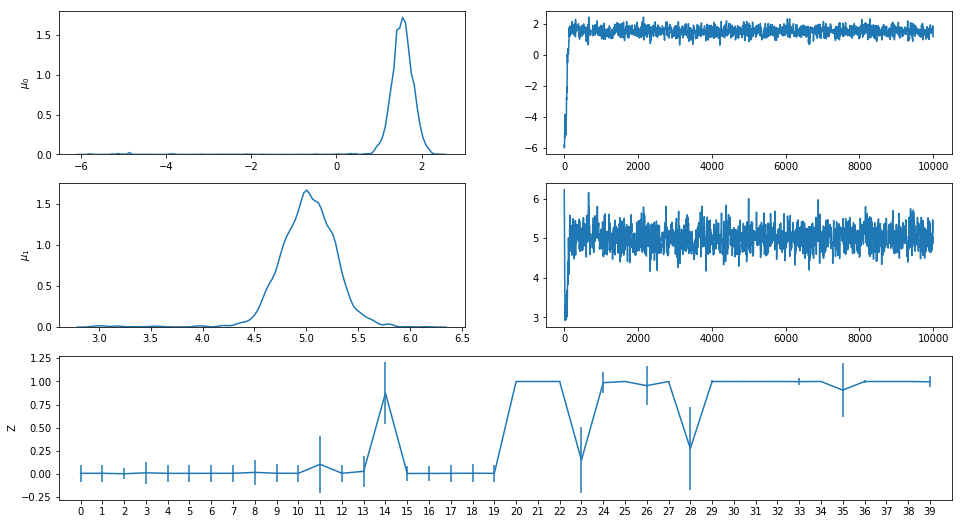

In [36]:
import seaborn as sns

plt.figure(figsize=(16,9))
plt.subplot(3,2,1)
sns.kdeplot(mu0s);
plt.ylabel('$\\mu_0$')
plt.subplot(3,2,2)
plt.plot(mu0s)

plt.subplot(3,2,3)
sns.kdeplot(mu1s);
plt.ylabel('$\\mu_1$')
plt.subplot(3,2,4)
plt.plot(mu1s)

plt.subplot(3,1,3)
plt.errorbar(np.arange(2*N), np.mean(Zs, axis=0), yerr=np.std(Zs, axis=0))
plt.xlim([-1,2*N])
plt.xticks(range(2*N))
plt.ylabel('Z');

In [37]:
print('mu0: %g +- %g [true value: %g]' % (np.mean(mu0s[2000:]), np.std(mu0s[2000:]), true_mu0))
print('mu1: %g +- %g [true value: %g]' % (np.mean(mu1s[2000:]), np.std(mu1s[2000:]), true_mu1))

mu0: 1.54309 +- 0.233344 [true value: 2]
mu1: 5.0145 +- 0.242178 [true value: 5]


For example in notebook 3g, while we can derive the conditional probability for the latent indicator variables $Z_{i,j}$ it is very difficult to derive the conditionals for the other variables.

## References

1. Andrej Karpathy, Stanford. [Ising model example](https://cs.stanford.edu/people/karpathy/visml/ising_example.html).